# Imports / Setup

In [120]:
import pandas as pd
# pd.options.display.max_columns = 50
# pd.options.display.max_colwidth = 150
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,\
                                    GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
sw = stopwords.words('english')

from wordcloud import WordCloud

import sys
sys.path.append( '../../src' )
from pandas_functions import *

# Helper Functions/Code

Courtesy of Flatiron's lecture materials, my colleague Saad, and various others - credit due to Daniel on helping me figure out the regex pattern to exclude Twitter mentions.

In [197]:
def prepare_doc(doc, stem=True):
    
    # Establish regex pattern, instantiate tokenizer
    # The regex pattern also excludes @mentions utilizing a
    # negative lookbehind
    regex_token = RegexpTokenizer(r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:’[a-z]+)?)")
    # Create tokens for doc
    doc = regex_token.tokenize(doc)
    # Lowercase all words
    doc = [word.lower() for word in doc]
    # Remove stopwords
    doc = [word for word in doc if word not in sw]
    # Stem!
    stemmer = SnowballStemmer("english")
    if stem:
        doc = [stemmer.stem(word) for word in doc]
    return ' '.join(doc)


def cv_printScores(cv_metric):
    print('CV Results')
    print('='*32)
    print('Accuracy')
    print('-'*32)
    print(f"Training accuracy: {cv_metric['train_accuracy'].mean():.3f}")
    print(f"Test accuracy:     {cv_metric['test_accuracy'].mean():.3f}\n")
    print('F-1 Score')
    print('-'*32)
    print(f"Training F1 score: {cv_metric['train_f1_macro'].mean():.3f}")
    print(f"Test F1 score:     {cv_metric['test_f1_macro'].mean():.3f}")
    print('-'*32'/n')
    print(f"Accuracy difference: {(cv_metric['train_accuracy'].mean()) - (cv_metric['test_accuracy'].mean()):.3f}")
    print(f"F1 score difference: {(cv_metric['train_f1_macro'].mean()) - (cv_metric['test_f1_macro'].mean()):.3f}")

In [198]:
regex_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)"

# Data: Loading, Cleaning, and Munging

In [123]:
df = pd.read_csv('../../data/judge_1377884607_tweet_product_company.csv')

In [124]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


This line of code is used to print an example tweet from the dataset; this was helpful in creating a functional regular expression pattern using outside web tools.

In [125]:
df.iloc[666].tweet_text

'I won the iPad accessories bag! Thanks @mention #SXSW'

Let's rename the columns for ease of use. Note that `product` is a reserved word in Python; for the second column, initially titled `emotion_in_tweet_is_directed_at`, I use `product_name`.

In [126]:
df.rename(columns = {'tweet_text': 'text',
                     'emotion_in_tweet_is_directed_at': 'product_name',
                     'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'},
               inplace = True)

Checking for nulls...

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          8720 non-null   object
 1   product_name  3169 non-null   object
 2   emotion       8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


Lots of nulls in `product_name`, which we'll have to deal with at one point or another, and exactly *one* null value in the `text` column. Let's check that out real quick...

In [128]:
df.loc[df['text'].isna()]

,text,product_name,emotion
6,NaN,NaN,No emotion toward brand or product


Totally empty. We can drop that.

In [129]:
df.dropna(subset=['text'],
          inplace=True)

## Distribution of target values

Let's get a look of how the target column (`emotion`) and the third column, `product_name`, are distributed.

In [130]:
print(f"Product name value counts:\n{df.product_name.value_counts()}")
print('-' * 32)
print(f"Emotion value counts:\n{df.emotion.value_counts()}")
print('-' * 32)
print(f"Emotion value counts (normalized):\n{df.emotion.value_counts(normalize=True)}")

Product name value counts:
iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: product_name, dtype: int64
--------------------------------
Emotion value counts:
No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64
--------------------------------
Emotion value counts (normalized):
No emotion toward brand or product    0.591170
Positive emotion                      0.329014
Negative emotion                      0.062500
I can't tell                          0.017317
Name: emotion, dtype: float64


In [131]:
df.emotion.value_counts(normalize=True).values

array([0.59116972, 0.32901376, 0.0625    , 0.01731651])

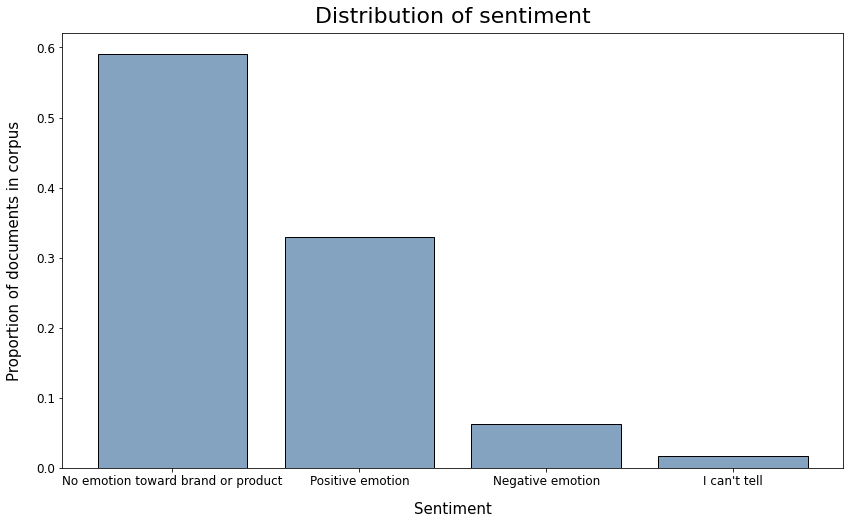

In [132]:
fig, ax = plt.subplots(figsize = (14, 8))

ax.bar(x = df.emotion.value_counts(normalize=True).index,
       height = df.emotion.value_counts(normalize=True).values,
       color = (0.2, 0.4, 0.6, 0.6),
       edgecolor = 'black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel(xlabel="Sentiment",
              fontsize=15,
              labelpad=14)
ax.set_ylabel(ylabel="Proportion of documents in corpus",
              fontsize=15,
              labelpad=14)
ax.set_title(label="Distribution of sentiment",
             fontsize=22,
             pad=10);

`I can't tell` makes up less than 2% of our dataset, and doesn't offer much more information in the way of word significance than the tweets labeled `No emotion toward brand or product`. It might be worth dropping records where `emotion` has been recorded as `I can't tell`.

In [133]:
df.drop(
    index = df[df.emotion == "I can't tell"].index,
    inplace = True)

df.head()

,text,product_name,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [134]:
sample1 = df.iloc[10].text

In [135]:
# Testing the custom function from up top
prepare_doc(doc=sample1,
            stem=True)

'find amp start impromptu parti sxsw http bit ly gvlrin wait til android app come'

In [136]:
df.loc[df.emotion == "No emotion toward brand or product"]

,text,product_name,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product
...,...,...,...
8715,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [137]:
df.iloc[33].text

'Anyone at  #SXSW who bought the new iPad want to sell their older iPad to me?'

## Stemming

In [138]:
full_text = df['text'].apply(lambda x: prepare_doc(x, stem=True))

full_text

0       iphon hrs tweet rise dead need upgrad plugin s...
1       know awesom ipad iphon app like appreci design...
2                                wait ipad also sale sxsw
3             hope year festiv crashi year iphon app sxsw
4       great stuff fri sxsw marissa mayer googl tim r...
                              ...                        
8716                             ipad everywher sxsw link
8717    wave buzz rt interrupt regular schedul sxsw ge...
8718    googl zeiger physician never report potenti ae...
8719    verizon iphon custom complain time fell back h...
8720                  rt googl test check offer sxsw link
Name: text, Length: 8569, dtype: object

In [139]:
df['tokens'] = full_text

df.head()

,text,product_name,emotion,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,iphon hrs tweet rise dead need upgrad plugin s...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer googl tim r...


In [140]:
df['text'][:20]

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
11    Find &amp; Start Impromptu Parties at #SXSW Wi...
12    Foursquare ups the game, just in time for #SXS...
13    Gotta love this #SXSW Google Calendar featurin...
14    Great #sxsw ipad app from @madebymany: http://...
15    haha, awesomely rad iPad app by @madebymany ht...
16    Holler Gram for iPad on the iTunes App Store -...
17    I just noticed DST is coming this weekend. How...
18    Just added my #SXSW flights to @planely. M

In [141]:
df['tokens'][:20]

0     iphon hrs tweet rise dead need upgrad plugin s...
1     know awesom ipad iphon app like appreci design...
2                              wait ipad also sale sxsw
3           hope year festiv crashi year iphon app sxsw
4     great stuff fri sxsw marissa mayer googl tim r...
5     new ipad app speechtherapi communic showcas sx...
7     sxsw start ctia around corner googleio hop ski...
8     beauti smart simpl idea rt wrote hollergram ip...
9     count day sxsw plus strong canadian dollar mea...
10    excit meet sxsw show sprint galaxi still run a...
11    find amp start impromptu parti sxsw http bit l...
12    foursquar up game time sxsw http j mp grn stil...
13    gotta love sxsw googl calendar featur top part...
14                 great sxsw ipad app http tinyurl com
15    haha awesom rad ipad app http bit ly htdfim ho...
16    holler gram ipad itun app store http co kfn vi...
17    notic dst come weekend mani iphon user hour la...
18    ad sxsw flight match peopl plane airport a

In [142]:
word_freq = FreqDist()

for tweet in df['text'].map(lambda x: prepare_doc(x, stem = False)):
    for word in tweet.split():
        word_freq[word] += 1
        
word_freq.most_common(n = 50)

[('sxsw', 9108),
 ('link', 4077),
 ('rt', 2925),
 ('ipad', 2848),
 ('google', 2504),
 ('apple', 2184),
 ('quot', 1582),
 ('iphone', 1497),
 ('store', 1397),
 ('new', 1057),
 ('austin', 919),
 ('amp', 803),
 ('app', 791),
 ('circles', 639),
 ('social', 632),
 ('launch', 628),
 ('today', 566),
 ('android', 563),
 ('pop', 543),
 ('network', 447),
 ('via', 400),
 ('line', 391),
 ('get', 383),
 ('free', 378),
 ('called', 353),
 ('mobile', 342),
 ('party', 335),
 ('sxswi', 333),
 ('major', 301),
 ('one', 297),
 ('like', 275),
 ('w', 260),
 ('time', 259),
 ('check', 257),
 ('temporary', 254),
 ('opening', 242),
 ('possibly', 240),
 ('day', 228),
 ('people', 223),
 ('see', 217),
 ('downtown', 216),
 ('mayer', 212),
 ('great', 211),
 ('going', 211),
 ('maps', 211),
 ('apps', 209),
 ('go', 201),
 ('popup', 198),
 ('need', 196),
 ('open', 193)]

Looking at the total value counts, we can identify some other tokens/words that might be worth adding to our stopwords list:
- `sxsw` & `sxswi` / `austin` - tokens that refer to setting - all tweets in corpus seem to be pulled from a South by Southwest (SXSW) festival event.
- `rt` / `link` / `quot` / `mobile` - tokens that refer to Twitter interactions or metadata about the post itself; not semanticaly useful information
- `amp` - ampersand (&) character that was improperly transcoded

In [143]:
sw.extend([
    'sxsw',
    'sxswi',
    'austin',
    'rt',
    'quot',
    'mention',
    'link',
    'amp',
    'mobil'
])

In [144]:
le = LabelEncoder()

df['target'] = le.fit_transform(df['emotion'])

le.classes_

array(['Negative emotion', 'No emotion toward brand or product',
       'Positive emotion'], dtype=object)

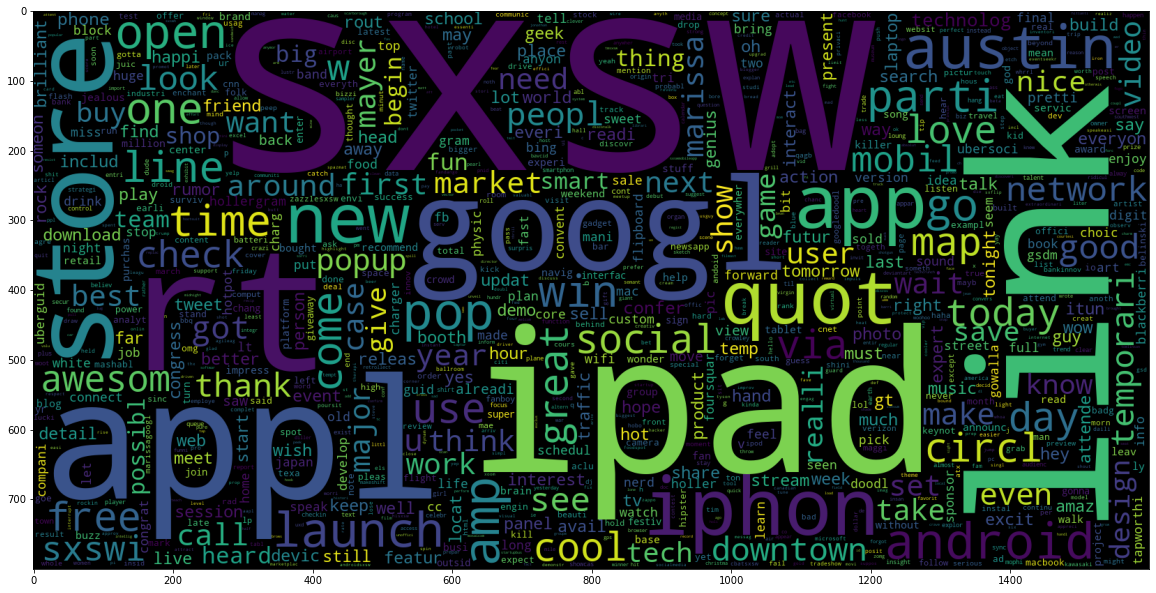

In [145]:
pos_df = df.loc[df['target'] == 2]

data_pos = pos_df.tokens

plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000,
               width = 1600,
               height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc);

## Trimming the dataframe display

In [177]:
corpus = df[['text', 'target']]

In [178]:
corpus

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,2
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,2
...,...,...
8716,Ipad everywhere. #SXSW {link},2
8717,"Wave, buzz... RT @mention We interrupt your re...",1
8718,"Google's Zeiger, a physician never reported po...",1
8719,Some Verizon iPhone customers complained their...,1


In [179]:
X = corpus.text
y = corpus.target

In [180]:
corpus

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,2
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,2
...,...,...
8716,Ipad everywhere. #SXSW {link},2
8717,"Wave, buzz... RT @mention We interrupt your re...",1
8718,"Google's Zeiger, a physician never reported po...",1
8719,Some Verizon iPhone customers complained their...,1


In [181]:
X = corpus.text
y = corpus.target

In [182]:
X

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
8716                        Ipad everywhere. #SXSW {link}
8717    Wave, buzz... RT @mention We interrupt your re...
8718    Google's Zeiger, a physician never reported po...
8719    Some Verizon iPhone customers complained their...
8720    �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...
Name: text, Length: 8569, dtype: object

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 138)

# Vectorizing

## `CountVectorizer`

In [184]:
# c_vec = CountVectorizer(token_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)",
#                         stop_words = sw,
#                         preprocessor = prepare_doc)

# X_tr_vec = c_vec.fit_transform(X_train)

# X_tr_vec = pd.DataFrame.sparse.from_spmatrix(X_tr_vec)

# X_tr_vec.columns = sorted(c_vec.vocabulary_)

# X_tr_vec.set_index(y_train.index,
#                    inplace = True)

# X_tr_vec

## `TfidfVectorizer`

In [185]:
# ti_vec = TfidfVectorizer(token_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)",
#                          stop_words = sw,
#                          preprocessor = prepare_doc)

# X_tr_vec = ti_vec.fit_transform(X_train)

# # Convert sparse, vectorized matrix to dataframe object
# X_tr_vec = pd.DataFrame.sparse.from_spmatrix(X_tr_vec)

# # Grab tokens from fitted vectorizer, sort, assign to columns
# X_tr_vec.columns = sorted(ti_vec.vocabulary_)

# # Match index to target
# X_tr_vec.set_index(y_train.index,
#                    inplace = True)

# # Display
# X_tr_vec

# Modeling

## Pipelines

## Multinomial Naive Bayes + Count Vectorizer

In [186]:
c_vec = CountVectorizer(token_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)",
                        stop_words = sw,
                        preprocessor = prepare_doc,
                        max_features = 1000)

X_tr_c_vec = c_vec.fit_transform(X_train)

X_tr_c_vec = pd.DataFrame.sparse.from_spmatrix(X_tr_c_vec)

X_tr_c_vec.columns = sorted(c_vec.vocabulary_)

X_tr_c_vec.set_index(y_train.index,
                   inplace = True)

X_tr_c_vec

,abl,abt,acc,access,aclu,across,action,actual,ad,adopt,...,yep,yes,yesterday,yet,yr,yrs,z,zazzlesxsw,zlf,zomb
8637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
mnb = MultinomialNB()

mnb_cv_one = cross_validate(mnb,
                            X_tr_c_vec,
                            y_train,
                            cv = 5,
                            scoring = ('accuracy', 'f1_macro'),
                            verbose = 1,
                            n_jobs = -2,
                            return_train_score = True)

cv_printScores(mnb_cv_one)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.716
Test accuracy:     0.633

F-1 Score
--------------------------------
Training F1 score: 0.640
Test F1 score:     0.524
--------------------------------
Accuracy difference: 0.083
F1 score difference: 0.116


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.4s finished


**Way** overfit!

## Multinomial Naive Bayes + TF-IDF Vectorizer

In [188]:
ti_vec = TfidfVectorizer(token_pattern = r"(?<![@A-Za-z0-9_])([a-zA-Z]+(?:'[a-z]+)?)",
                         stop_words = sw,
                         preprocessor = prepare_doc,
                         max_features = 1000)

X_tr_ti_vec = ti_vec.fit_transform(X_train)

# Convert sparse, vectorized matrix to dataframe object
X_tr_ti_vec = pd.DataFrame.sparse.from_spmatrix(X_tr_ti_vec)

# Grab tokens from fitted vectorizer, sort, assign to columns
X_tr_ti_vec.columns = sorted(ti_vec.vocabulary_)

# Match index to target
X_tr_ti_vec.set_index(y_train.index,
                   inplace = True)

# Display
X_tr_ti_vec

,abl,abt,acc,access,aclu,across,action,actual,ad,adopt,...,yep,yes,yesterday,yet,yr,yrs,z,zazzlesxsw,zlf,zomb
8637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
mnb_two = MultinomialNB()

mnb_cv_two = cross_validate(estimator = mnb_two,
                            X = X_tr_ti_vec,
                            y = y_train,
                            scoring = ('accuracy', 'f1_macro'),
                            verbose = 1,
                            n_jobs = -2,
                            return_train_score = True)

cv_printScores(mnb_cv_two)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.721
Test accuracy:     0.670

F-1 Score
--------------------------------
Training F1 score: 0.500
Test F1 score:     0.442
--------------------------------
Accuracy difference: 0.051
F1 score difference: 0.057


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.6s finished


## Random Forest Classifier + Count Vectorizer

In [201]:
rfc = RandomForestClassifier(max_depth = 50)

rfc_cv_one = cross_validate(rfc,
                            X_tr_c_vec,
                            y_train,
                            cv = 5,
                            scoring = ('accuracy', 'f1_macro'),
                            verbose = 1,
                            n_jobs = -2,
                            return_train_score = True)

cv_printScores(rfc_cv_one)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.845
Test accuracy:     0.676

F-1 Score
--------------------------------
Training F1 score: 0.773
Test F1 score:     0.469
--------------------------------
Accuracy difference: 0.170
F1 score difference: 0.304


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    4.9s finished


## Random Forest Classifier + TF-IDF Vectorizer

In [202]:
rfc_two = RandomForestClassifier(max_depth = 50)

rfc_cv_two = cross_validate(rfc_two,
                            X_tr_ti_vec,
                            y_train,
                            cv = 5,
                            scoring = ('accuracy', 'f1_macro'),
                            verbose = 1,
                            n_jobs = -2,
                            return_train_score = True)

cv_printScores(rfc_cv_two)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Results
Accuracy
--------------------------------
Training accuracy: 0.850
Test accuracy:     0.673

F-1 Score
--------------------------------
Training F1 score: 0.758
Test F1 score:     0.454
--------------------------------
Accuracy difference: 0.178
F1 score difference: 0.304


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    4.7s finished


# Scrap Code